In [1]:
from IPython import display
from ipywidgets import Image

import os
import datajoint as dj

In [2]:
schema = dj.schema('dimitri_filepath')

Connecting dimitri@localhost:3306


In [4]:
schema.drop()  # drop schema to start demo from scratch

Proceed to delete entire schema `dimitri_filepath`? [yes, No]: yes


In [5]:
schema = dj.schema('dimitri_filepath')

In [6]:
## Storage configuration

# set up stores
dj.config['stores'] = {
    'remote': dict(   # store in minio
        stage=os.path.abspath('./stage'),
        protocol='s3',
        endpoint='localhost:9000',
        access_key='datajoint',
        secret_key='datajoint',
        bucket='datajoint-demo',        
        location='code-clinic'),   
    }

## Download some images off the web into ./stage

In [7]:
# Step 1: Find a bunch of images on the web
logos = dict(
    ucsd='https://upload.wikimedia.org/wikipedia/commons/f/f6/UCSD_logo.png',
    datajoint='https://datajoint.io/static/images/DJiotitle.png',
    utah='https://umc.utah.edu/wp-content/uploads/sites/15/2015/01/Ulogo_400p.png',
    bcm='https://upload.wikimedia.org/wikipedia/commons/5/5d/Baylor_College_of_Medicine_Logo.png',
    pydata='https://pydata.org/wp-content/uploads/2018/10/pydata-logo.png',
    python='https://www.python.org/static/community_logos/python-logo-master-v3-TM.png',
    pni='https://vathes.com/2018/05/24/Princeton-Neuroscience-Institute-Partners-with-Vathes-to-Support-the-Adoption-of-DataJoint/PNI%20logo.png')

In [8]:
Image.from_url(logos['python'])

Image(value=b'https://www.python.org/static/community_logos/python-logo-master-v3-TM.png', format='url')

In [9]:
@schema
class Organization(dj.Lookup):
    definition = """
    organization : varchar(30)
    --- 
    logo_url : varchar(255)
    """
    contents = logos.items()

In [10]:
Organization()

organization,logo_url
bcm,https://upload.wikimedia.org/wikipedia/commons/5/5d/Baylor_College_of_Medicine_Logo.png
datajoint,https://datajoint.io/static/images/DJiotitle.png
pni,https://vathes.com/2018/05/24/Princeton-Neuroscience-Institute-Partners-with-Vathes-to-Support-the-Adoption-of-DataJoint/PNI%20logo.png
pydata,https://pydata.org/wp-content/uploads/2018/10/pydata-logo.png
python,https://www.python.org/static/community_logos/python-logo-master-v3-TM.png
ucsd,https://upload.wikimedia.org/wikipedia/commons/f/f6/UCSD_logo.png
utah,https://umc.utah.edu/wp-content/uploads/sites/15/2015/01/Ulogo_400p.png


In [11]:
import requests 

@schema
class Logo(dj.Imported):
    definition = """
    -> Organization
    ---
    logo_image : filepath@remote
    """
    
    path = os.path.join(dj.config['stores']['remote']['stage'], 'organizations', 'logos')
    
    def make(self, key):
        # create the subfolder and download the logo into local_file 
        os.makedirs(self.path, exist_ok=True)
        url = (Organization & key).fetch1('logo_url')
        local_file = os.path.join(self.path, key['organization'] + os.path.splitext(url)[1])
        print(local_file)
        with open(local_file, 'wb') as f:
            f.write(requests.get(url).content)
        # sync up
        self.insert1(dict(key, logo_image=local_file))        

In [12]:
Logo.populate()

/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/bcm.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/datajoint.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pni.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pydata.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/python.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/ucsd.png
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/utah.png


In [13]:
Logo()

organization,logo_image
pydata,=BLOB=
utah,=BLOB=
datajoint,=BLOB=
ucsd,=BLOB=
pni,=BLOB=
python,=BLOB=
bcm,=BLOB=


In [14]:
Logo.fetch(as_dict=True)

[{'organization': 'pydata',
  'logo_image': PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pydata.png')},
 {'organization': 'utah',
  'logo_image': PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/utah.png')},
 {'organization': 'datajoint',
  'logo_image': PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/datajoint.png')},
 {'organization': 'ucsd',
  'logo_image': PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/ucsd.png')},
 {'organization': 'pni',
  'logo_image': PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pni.png')},
 {'organization': 'python',
  'logo_image': PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/python.png')},
 {'organization': 'bcm',
  'logo_image': PosixPath('/home/dimitri/dev/db-programming

In [15]:
# delete the local repository completely
import shutil
shutil.rmtree(dj.config['stores']['remote']['stage'])

In [16]:
paths = Logo().fetch('logo_image')

In [17]:
paths

array([PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pydata.png'),
       PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/utah.png'),
       PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/datajoint.png'),
       PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/ucsd.png'),
       PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/pni.png'),
       PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/python.png'),
       PosixPath('/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/organizations/logos/bcm.png')],
      dtype=object)

In [18]:
Image.from_file(paths[4])

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xfb\x00\x00\x00\xc9\x08\x03\x00\x00\x00\xd2\x1e\…

In [19]:
(Logo & 'organization in ("datajoint", "bcm")').delete()

About to delete:
`dimitri_filepath`.`_logo`: 2 items
Proceed? [yes, No]: yes
Committed.


In [20]:
ext = schema.external['remote']

In [21]:
ext

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
3fd4b79b-9fdd-95c0-4074-68614d97f7e1,162,None,organizations/logos/pydata.png,bc56979a-0b38-1a79-1dd5-9713198a87fb,2019-09-20 20:29:40
56c820a9-e83c-02c9-8e76-7ba908192588,13216,None,organizations/logos/utah.png,1c755e4b-a65f-5576-352e-729f0c5987da,2019-09-20 20:29:40
6e7ba0be-2171-a2ab-163e-ff12b0943e8e,36444,None,organizations/logos/datajoint.png,9e902f2f-726a-2da5-0a24-ee3b97892f8a,2019-09-20 20:29:39
81dc7dae-bebc-6d38-b891-c48eee8e340a,33734,None,organizations/logos/ucsd.png,914f5b55-ea69-7489-d45b-031bec3ecaa5,2019-09-20 20:29:40
8c25c65d-506d-f382-0e36-88e1f6057ea3,6293,None,organizations/logos/pni.png,0d59845d-5c75-24f8-20c8-9637517ed6a7,2019-09-20 20:29:39
f35b5a91-38cb-bc7f-ef17-b2ce94bb0131,83564,None,organizations/logos/python.png,3cf229ee-dc09-2549-277e-8859aad2fca5,2019-09-20 20:29:40
f97ea212-5794-926a-d852-deffc0f10bba,227965,None,organizations/logos/bcm.png,10ee4617-a63f-61ba-2807-35a266a9f488,2019-09-20 20:29:39


In [22]:
ext.unused()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
6e7ba0be-2171-a2ab-163e-ff12b0943e8e,36444,None,organizations/logos/datajoint.png,9e902f2f-726a-2da5-0a24-ee3b97892f8a,2019-09-20 20:29:39
f97ea212-5794-926a-d852-deffc0f10bba,227965,None,organizations/logos/bcm.png,10ee4617-a63f-61ba-2807-35a266a9f488,2019-09-20 20:29:39


In [23]:
ext.unused().fetch_external_paths()

[(UUID('6e7ba0be-2171-a2ab-163e-ff12b0943e8e'),
  PurePosixPath('code-clinic/organizations/logos/datajoint.png')),
 (UUID('f97ea212-5794-926a-d852-deffc0f10bba'),
  PurePosixPath('code-clinic/organizations/logos/bcm.png'))]

In [24]:
ext.delete()

100%|██████████| 2/2 [00:00<00:00, 67.15it/s]


[]

In [25]:
ext.unused()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp


In [26]:
states = dict(
    AL='Alabama',        AK='Alaska',       AZ='Arizona',      AR='Arkansas',
    CA='California',     CO='Colorado',     CT='Connecticut',  DE='Delaware',
    FL='Florida',        GA='Georgia',      HI='Hawaii',       ID='Idaho', 
    IL='Illinois',       IN='Indiana',      IA='Iowa',         KS='Kansas',
    KY='Kentucky',       LA='Louisiana',    ME='Maine',        MD='Maryland',
    MA='Massachusetts',  MI='Michigan',     MN='Minnesota',    MS='Mississippi',
    MO='Missouri',       MT='Montana',      NE='Nebraska',     NV='Nevada',
    NH='New Hampshire',  NJ='New Jersey',   NM='New Mexico',   NY='New York',
    NC='North Carolina', ND='North Dakota', OH='Ohio',         OK='Oklahoma',
    OR='Oregon',         PA='Pennsylvania', RI='Rhode Island', SC='South Carlina',
    SD='South Dakota',   TN='Tennessee',    TX='Texas',        UT='Utah',
    VT='Vermont',        VA='Virginia',     WA='Washington',   WV='West Virginia', 
    WI='Wisconsin',      WY='Wyoming')

In [27]:
@schema
class State(dj.Lookup):
    definition = """
    # United States
    state_code : char(2)
    ---
    state : varchar(20)
    """
    contents = states.items()

In [28]:
State()

state_code,state
AK,Alaska
AL,Alabama
AR,Arkansas
AZ,Arizona
CA,California
CO,Colorado
CT,Connecticut


In [29]:
@schema
class StateBird(dj.Imported):
    definition = """
    -> State
    ---
    bird_image : filepath@remote    
    """
    path = os.path.join(dj.config['stores']['remote']['stage'], 'states', 'birds')
    
    
    def make(self, key):
        os.makedirs(self.path, exist_ok=True)
        state = (State & key).fetch1('state')
        url = "http://www.theus50.com/images/state-birds/{state}-bird.jpg".format(state=state.lower())
        local_file = os.path.join(self.path, state.lower() + os.path.splitext(url)[1])
        print(local_file)
        with open(local_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, bird_image=local_file))        


In [30]:
StateBird.populate()

/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/alaska.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/alabama.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/arkansas.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/arizona.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/california.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/colorado.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/connecticut.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/delaware.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/florida.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/georgia.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/birds/hawaii.jpg
/home/dimitri

In [31]:
@schema
class StateFlower(dj.Imported):
    definition = """
    -> State
    ---
    flower_image : filepath@remote    
    """
    path = os.path.join(dj.config['stores']['remote']['stage'],'states', 'flowers')
    
    
    def make(self, key):
        os.makedirs(self.path, exist_ok=True)
        state = (State & key).fetch1('state')
        url = "http://www.theus50.com/images/state-birds/{state}-flower.jpg".format(state=state.lower())
        local_file = os.path.join(self.path, state.lower() + os.path.splitext(url)[1])
        print(local_file)
        with open(local_file, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, flower_image=local_file))     

In [32]:
StateFlower().populate()

/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/alaska.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/alabama.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/arkansas.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/arizona.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/california.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/colorado.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/connecticut.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/delaware.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/florida.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/georgia.jpg
/home/dimitri/dev/db-programming-with-datajoint/notebooks/stage/states/flowers/ha

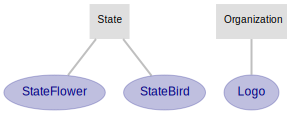

In [33]:
dj.Diagram(schema)

In [35]:
schema.external

External file tables for schema `dimitri_filepath`:
    "remote" s3:code-clinic"

In [36]:
schema.external['remote']

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp
01d9c579-f923-81d1-8f35-c7fddbf171f4,417,None,states/flowers/maine.jpg,980488b3-8709-9958-e741-77e8b22e6aed,2019-09-20 20:30:36
01f19f6d-e7d3-b718-8b1b-8122a2116973,25735,None,states/birds/texas.jpg,0c1f52a6-8cef-1534-3b5c-bb03f52f6b78,2019-09-20 20:30:27
02621cc5-6215-f043-2297-1844393d603b,416,None,states/flowers/iowa.jpg,2e98d103-ff1a-387f-f84b-a4653fe69b29,2019-09-20 20:30:34
0315aac9-440c-ed4f-f6d1-1581547212be,25142,None,states/birds/indiana.jpg,511d9eac-52a7-7a76-b60a-ed3131c08874,2019-09-20 20:30:23
0427f842-2a48-a302-af48-fc2973d8fbbe,25142,None,states/birds/kentucky.jpg,511d9eac-52a7-7a76-b60a-ed3131c08874,2019-09-20 20:30:24
056a7914-856d-3f8e-7880-6432ab313d58,425,None,states/flowers/west virginia.jpg,be37e4f6-93d3-3aa1-f326-b4c765c10648,2019-09-20 20:30:39
09adf4ec-d9c7-ee18-868e-e577a9ea8731,422,None,states/birds/south dakota.jpg,f6df925d-149e-9629-4d2d-82a6786fd92b,2019-09-20 20:30:27


In [38]:
schema.external['remote'].fetch_external_paths()

[(UUID('01d9c579-f923-81d1-8f35-c7fddbf171f4'),
  PurePosixPath('code-clinic/states/flowers/maine.jpg')),
 (UUID('01f19f6d-e7d3-b718-8b1b-8122a2116973'),
  PurePosixPath('code-clinic/states/birds/texas.jpg')),
 (UUID('02621cc5-6215-f043-2297-1844393d603b'),
  PurePosixPath('code-clinic/states/flowers/iowa.jpg')),
 (UUID('0315aac9-440c-ed4f-f6d1-1581547212be'),
  PurePosixPath('code-clinic/states/birds/indiana.jpg')),
 (UUID('0427f842-2a48-a302-af48-fc2973d8fbbe'),
  PurePosixPath('code-clinic/states/birds/kentucky.jpg')),
 (UUID('056a7914-856d-3f8e-7880-6432ab313d58'),
  PurePosixPath('code-clinic/states/flowers/west virginia.jpg')),
 (UUID('09adf4ec-d9c7-ee18-868e-e577a9ea8731'),
  PurePosixPath('code-clinic/states/birds/south dakota.jpg')),
 (UUID('0e1c29e6-6bf1-5d23-1e06-cc9ee05d79d9'),
  PurePosixPath('code-clinic/states/birds/north dakota.jpg')),
 (UUID('114da747-fee3-a47d-e90b-be2e1cc0bfe0'),
  PurePosixPath('code-clinic/states/flowers/washington.jpg')),
 (UUID('17f485a8-eca3-d74

In [39]:
schema.external['remote'].unused()

"hash hash of contents (blob), of filename + contents (attach), or relative filepath (filepath)",size size of object in bytes,attachment_name the filename of an attachment,filepath relative filepath or attachment filename,contents_hash used for the filepath datatype,timestamp automatic timestamp


## Remaining issues:

* Re-inserting the same filepath twice with different contents throws and error. This is fixed by deleting the unused external table entries.
* Users may need the option to fetch only the paths or object handles without downloading the files. Fetch option or config?
* Dropping the schema leaves orphaned externals. However, dropping tables works normally.
* Insert(query) with externals has not tested.